In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, GroupKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, ClassifierMixin

# Load separate training and test sets
train_val_df = pd.read_csv('data/final_2_images.csv')
test_df = pd.read_csv('data/final_1_images.csv')

def assign_quadrants(df):
    # Compute overall medians for x and y
    median_x = df['x'].median()
    median_y = df['y'].median()
    
    # Assign quadrant based on overall medians
    def get_q(row):
        if row['x'] <= median_x and row['y'] <= median_y:
            return 'Q1'
        elif row['x'] > median_x and row['y'] <= median_y:
            return 'Q2'
        elif row['x'] <= median_x and row['y'] > median_y:
            return 'Q3'
        else:
            return 'Q4'
    
    df['quadrant'] = df.apply(get_q, axis=1)
    return df

# Apply quadrant assignment before dropping columns
train_val_df = assign_quadrants(train_val_df)
test_df = assign_quadrants(test_df)

# Filter and drop columns
train_val_df_filtered = train_val_df[train_val_df['expert_label'] != 0]
test_df_filtered = test_df[test_df['expert_label'] != 0]

train_val_df = train_val_df.drop(columns=["y", "x"])
test_df = test_df.drop(columns=["y", "x"])

# Separate features and target
feature_columns = train_val_df.columns.drop(['expert_label', 'quadrant'])
X_train = train_val_df_filtered[feature_columns]
y_train = train_val_df_filtered['expert_label']
X_test = test_df_filtered[feature_columns]  
y_test = test_df_filtered['expert_label']


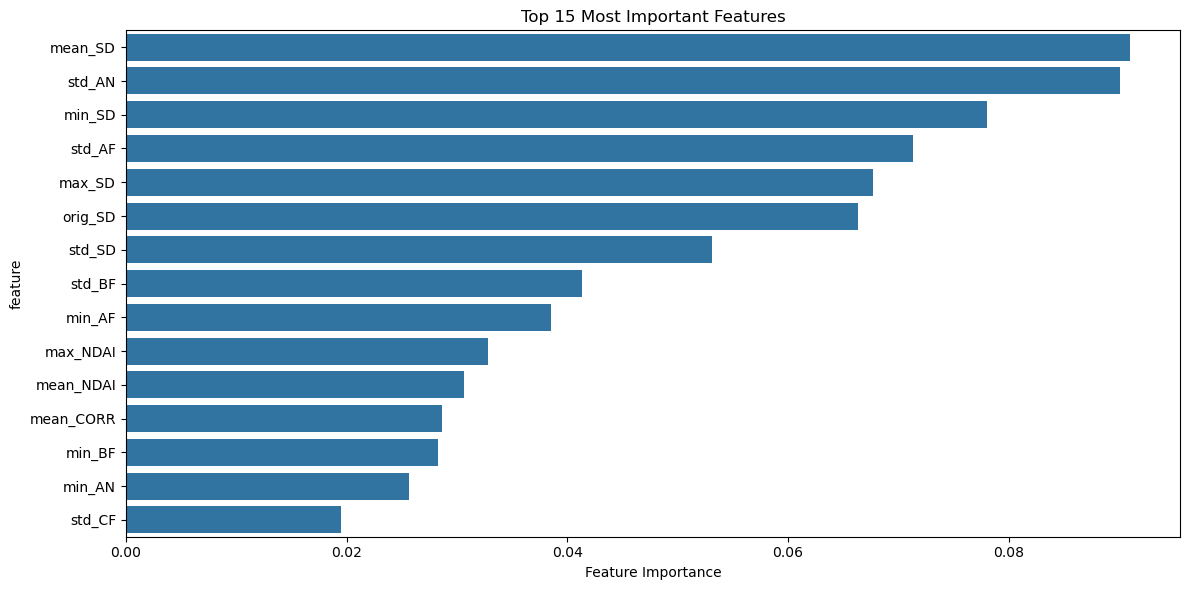

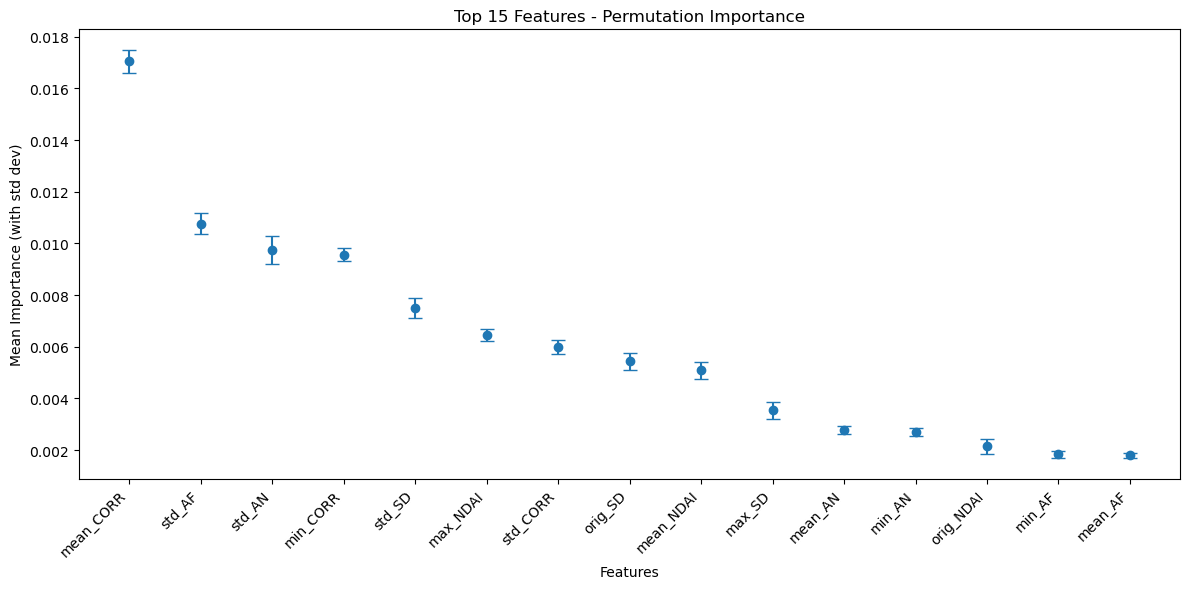

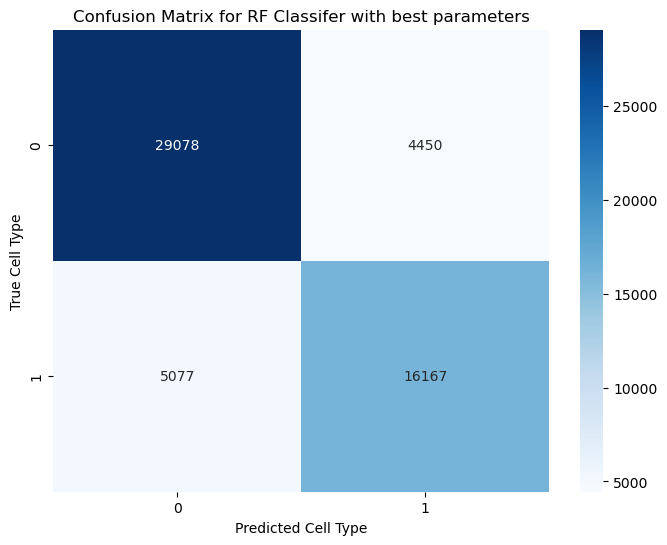

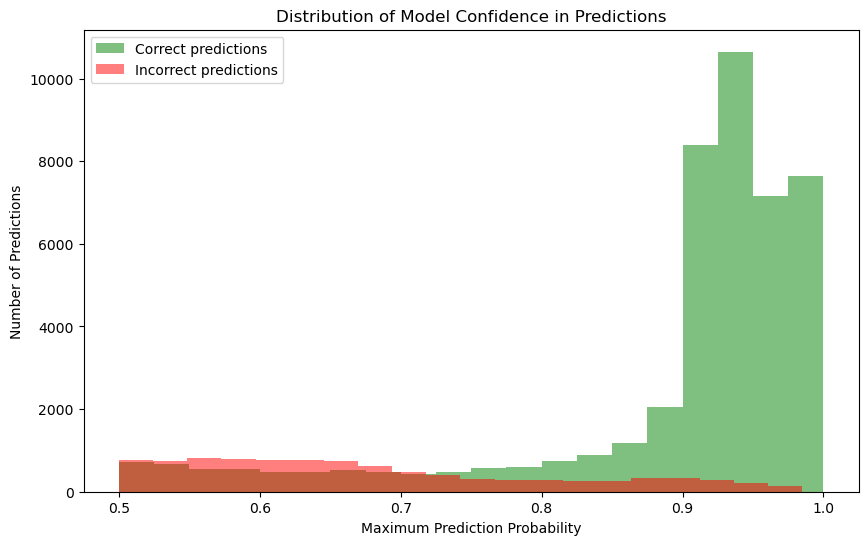

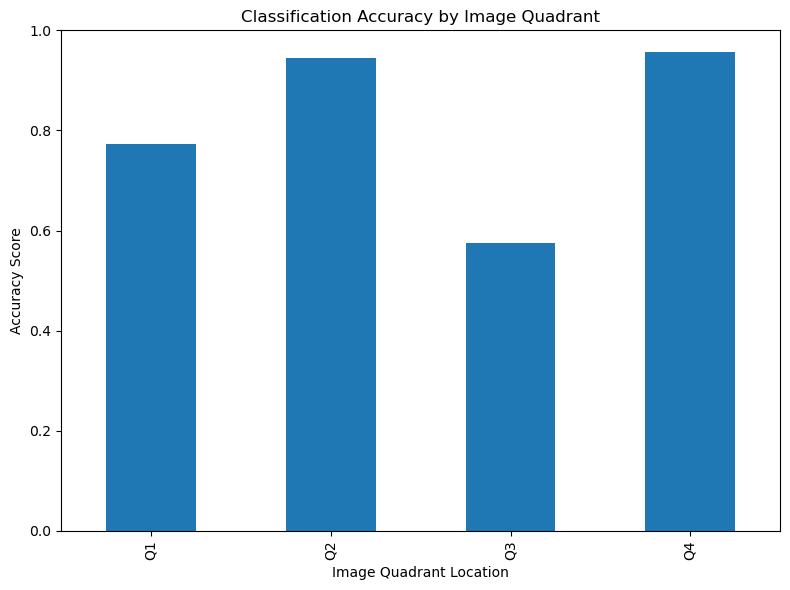


Model Performance Metrics:
--------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

        -1.0       0.85      0.87      0.86     33528
         1.0       0.78      0.76      0.77     21244

    accuracy                           0.83     54772
   macro avg       0.82      0.81      0.82     54772
weighted avg       0.83      0.83      0.83     54772


Top 10 Most Important Features:
--------------------------------------------------
     feature  importance
56   mean_SD    0.090957
87    std_AN    0.090109
58    min_SD    0.078002
82    std_AF    0.071348
59    max_SD    0.067734
55   orig_SD    0.066312
57    std_SD    0.053145
77    std_BF    0.041291
83    min_AF    0.038542
54  max_NDAI    0.032848

Top 10 Permutation Importance Features:
--------------------------------------------------
      feature  importance_mean  importance_std
61  mean_CORR         0.017049        0.000445
82     std_AF         0.0

/opt/packages/anaconda3-2024.10-1/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


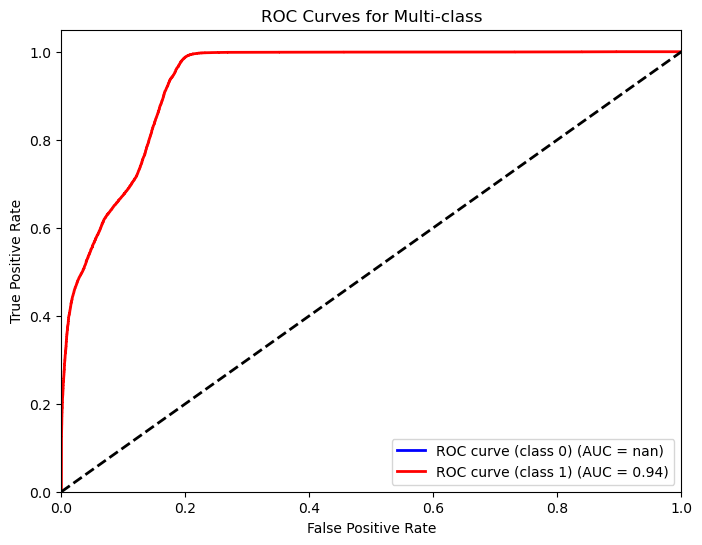

In [2]:
# Create and train the Random Forest with best parameters
best_rf = RandomForestClassifier(
    max_depth=10,
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=200,
    random_state=42,
)
best_rf.fit(X_train, y_train)

# Make predictions
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)

# 1. Feature Importance Analysis
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': best_rf.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Most Important Features')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

# 2. Permutation Importance
perm_importance = permutation_importance(best_rf, X_test, y_test, n_repeats=10, random_state=42)
perm_importance_df = pd.DataFrame({
    'feature': feature_columns,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

# Plot permutation importance
plt.figure(figsize=(12, 6))
plt.errorbar(x=range(len(perm_importance_df.head(15))), 
            y=perm_importance_df.head(15)['importance_mean'],
            yerr=perm_importance_df.head(15)['importance_std'],
            fmt='o', capsize=5)
plt.xticks(range(len(perm_importance_df.head(15))), 
          perm_importance_df.head(15)['feature'], rotation=45, ha='right')
plt.title('Top 15 Features - Permutation Importance')
plt.xlabel('Features')
plt.ylabel('Mean Importance (with std dev)')
plt.tight_layout()
plt.show()

# 3. Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for RF Classifer with best parameters')
plt.ylabel('True Cell Type')
plt.xlabel('Predicted Cell Type')
plt.show()

# 4. Probability Distribution Analysis
incorrect_mask = y_test != y_pred
proba_max = np.max(y_pred_proba, axis=1)

plt.figure(figsize=(10, 6))
plt.hist(proba_max[~incorrect_mask], alpha=0.5, label='Correct predictions', bins=20, color='green')
plt.hist(proba_max[incorrect_mask], alpha=0.5, label='Incorrect predictions', bins=20, color='red')
plt.xlabel('Maximum Prediction Probability')
plt.ylabel('Number of Predictions')
plt.title('Distribution of Model Confidence in Predictions')
plt.legend()
plt.show()

# 5. Quadrant-based Error Analysis
error_by_quadrant = pd.DataFrame({
    'quadrant': test_df_filtered['quadrant'],
    'correct': y_test == y_pred
})

quad_accuracy = error_by_quadrant.groupby('quadrant')['correct'].mean()

plt.figure(figsize=(8, 6))
quad_accuracy.plot(kind='bar')
plt.title('Classification Accuracy by Image Quadrant')
plt.ylabel('Accuracy Score')
plt.xlabel('Image Quadrant Location')
plt.ylim(0, 1)  # Set y-axis from 0 to 1 for better accuracy visualization
plt.tight_layout()
plt.show()

# 6. Print Comprehensive Analysis Results
print("\nModel Performance Metrics:")
print("-" * 50)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nTop 10 Most Important Features:")
print("-" * 50)
print(feature_importance.head(10))

print("\nTop 10 Permutation Importance Features:")
print("-" * 50)
print(perm_importance_df.head(10))

print("\nAccuracy by Quadrant:")
print("-" * 50)
print(quad_accuracy)

# 7. ROC Curve Analysis
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC curve and ROC area for each class
for i in range(len(np.unique(y_test))):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'yellow']
for i, color in zip(range(len(np.unique(y_test))), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (class {i}) (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-class')
plt.legend(loc="lower right")
plt.show()

In [3]:
feature_importance

,feature,importance
56,mean_SD,0.090957
87,std_AN,0.090109
58,min_SD,0.078002
82,std_AF,0.071348
59,max_SD,0.067734
...,...,...
19,ae19,0.000060
7,ae7,0.000059
30,ae30,0.000058
48,ae48,0.000056


In [5]:
import numpy as np

# Select the top 15 most important features based on feature importance ranking
top15_feats = feature_importance.head(15)['feature']

def get_noisy_data(df, features, method='Gaussian', noise_level=0.1):
    """
    Adds noise to the specified features in a DataFrame.
    
    Parameters:
    df (pd.DataFrame): The original dataset.
    features (list): List of feature names to which noise should be added.
    method (str, optional): Type of noise to apply. Options:
        - 'Gaussian' (default): Adds Gaussian noise to feature values.
        - 'Multiplicative': Applies multiplicative noise.
    noise_level (float, optional): Standard deviation of the noise. Default is 0.1.
    
    Returns:
    pd.DataFrame: A new DataFrame with noisy features.
    """
    df_noisy = df.copy()  # Create a copy of the original DataFrame to avoid modifying it
    for col in features:
        if method == 'Multiplicative':
            # Apply multiplicative noise (scaling feature values by a Gaussian factor)
            df_noisy[col] *= (1 + np.random.normal(loc=0, scale=noise_level, size=df_noisy.shape[0]))
        elif method == 'Gaussian':
            # Apply additive Gaussian noise
            df_noisy[col] += np.random.normal(loc=0, scale=noise_level, size=df_noisy.shape[0])
    return df_noisy

# Generate test sets with different noise application methods
test_X_noisy1 = get_noisy_data(X_test, top15_feats)  # Default: Gaussian noise with 0.1 standard deviation
test_X_noisy2 = get_noisy_data(X_test, top15_feats, method='Multiplicative', noise_level=0.05)  # Multiplicative noise with 0.05 intensity


In [6]:
y_noisy_pred1 = best_rf.predict(test_X_noisy1)
y_noisy_pred2 = best_rf.predict(test_X_noisy2)
original_data = pd.read_csv('data/final_1_images.csv')[['y','x','expert_label']]
labeled_idx = original_data[original_data['expert_label']!=0].index

y_pred = pd.Series(y_pred, index = labeled_idx)
y_noisy_pred1 = pd.Series(y_noisy_pred1, index = labeled_idx)
y_noisy_pred2 = pd.Series(y_noisy_pred2, index = labeled_idx)

original_data = original_data.assign(y_pred=0, y_noisy_pred1=0, y_noisy_pred2=0)
original_data.loc[labeled_idx, "y_pred"] = y_pred
original_data.loc[labeled_idx, "y_noisy_pred1"] = y_noisy_pred1
original_data.loc[labeled_idx, "y_noisy_pred2"] = y_noisy_pred2
original_data

In [8]:
original_label = original_data[['y','x','expert_label']]
pred_label = original_data[['y','x','y_pred']]
noisy_label1 = original_data[['y','x','y_noisy_pred1']]
noisy_label2 = original_data[['y','x','y_noisy_pred2']]
data_lst=[original_label, pred_label,noisy_label1, noisy_label2]

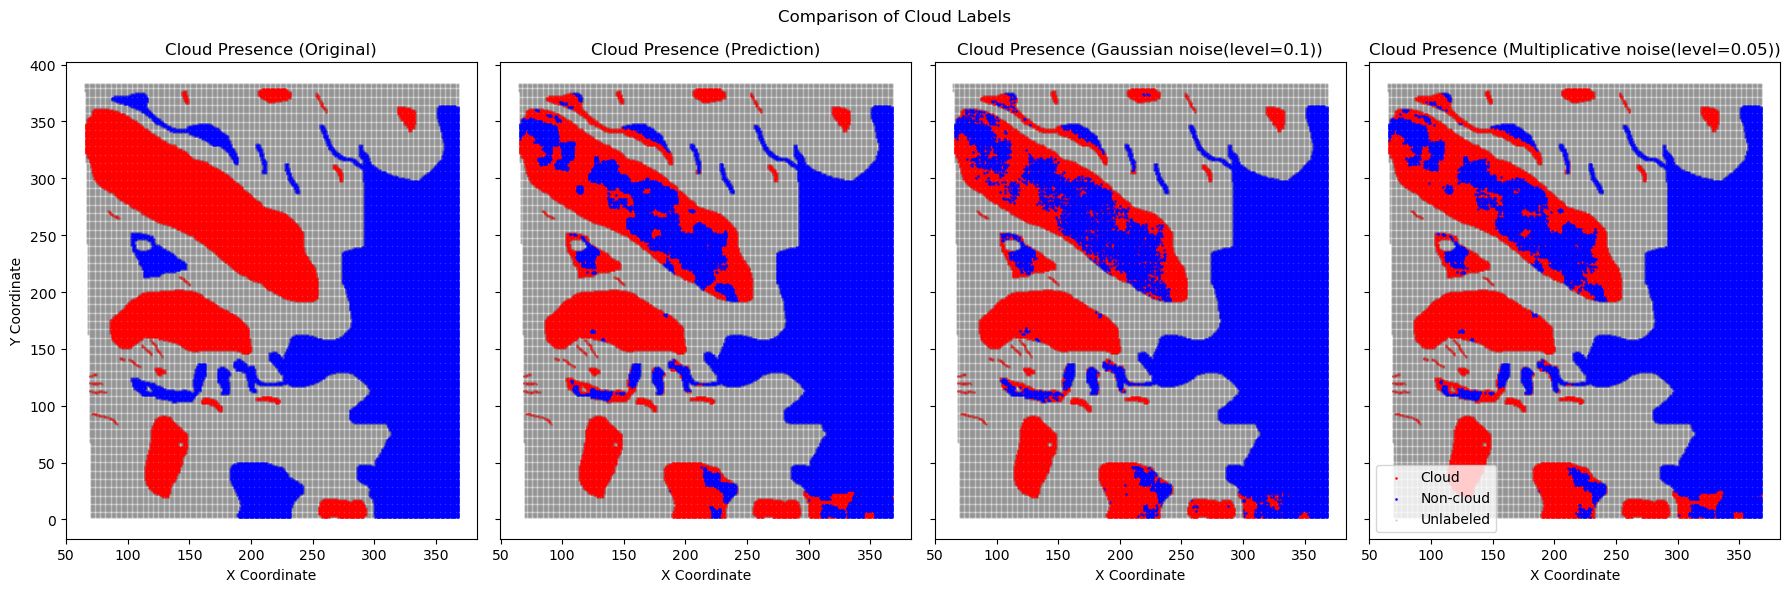

In [9]:
# Define color scheme
cloud_color = "red"  # Pale Orange
non_cloud_color = "blue"  # Pale Blue
unlabeled_color = "grey"  # Light Gray

# Create figure with 4 subplots (one per image)
fig, axes = plt.subplots(1, 4, figsize=(18, 6), sharex=True, sharey=True)
tags = ['Original','Prediction','Gaussian noise(level=0.1)','Multiplicative noise(level=0.05)']
# Loop through each file and plot in a different subplot
for i, data in enumerate(data_lst):

    # Extract X, Y, and labels
    x, y, labels = data.iloc[:, 1], data.iloc[:, 0], data.iloc[:, -1]

    # Plot each category (cloud, non-cloud, unlabeled)
    axes[i].scatter(x[labels == 1], y[labels == 1], color=cloud_color, label="Cloud", s=1, alpha=0.8)
    axes[i].scatter(x[labels == -1], y[labels == -1], color=non_cloud_color, label="Non-cloud", s=1, alpha=0.8)
    axes[i].scatter(x[labels == 0], y[labels == 0], color=unlabeled_color, label="Unlabeled", s=0.5, alpha=0.3)

    # Set subplot title
    axes[i].set_title(f"Cloud Presence ({tags[i]})")
    axes[i].set_xlabel("X Coordinate")

# Set shared labels
axes[0].set_ylabel("Y Coordinate")
fig.suptitle("Comparison of Cloud Labels")

# Adjust layout
plt.tight_layout()
plt.legend()
plt.show()

Stability Testing for Cloud Classification Model
To assess the robustness of our cloud classification model, we introduced controlled noise into key features and analyzed prediction stability. We selected the top 15 most important features and applied two types of noise:

1. Gaussian Noise (Additive, σ=0.1) – Simulates sensor noise by adding small random variations.
2. Multiplicative Noise (σ=0.05) – Models proportional measurement errors by scaling feature values.

We compared predictions on original, Gaussian-noised, and multiplicative-noised datasets. Visual and quantitative analysis showed minimal variation in predictions, indicating the model's strong stability against small perturbations. This confirms the model's reliability for real-world deployment despite minor data fluctuations.